In [1]:
import copy
import math
import random
from collections import OrderedDict, defaultdict

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from tqdm.auto import tqdm

import torch
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
import torchvision.models as models
import torchvision
from torch.utils.data import DataLoader

from torchvision.datasets import *
from torchvision.transforms import *

from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
from mobilenet_model.Q_layer import bn_folding_model, bn_folding, fold_conv_bn_eval
from mobilenet_model.Q_layer import get_scale_and_zero_point, linear_quantize
from mobilenet_model.Q_layer import quantized_linear, quantized_conv, do_requant, do_fake_quant,do_dequant
from mobilenet_model.Q_layer import AVP_Fake_Quant,Q_SELayer_deq, Q_SELayer, QuantizedConv, QuantizedLinear, Preprocess, Quantizer

from mobilenet_model.mobilenet_model import SELayer,h_swish,h_sigmoid
from mobilenet_model.mobilenet_model import _make_divisible
from mobilenet_model.mobilenet_model import Our_MobileNetV3,BN_fold_Our_MobileNetV3


no_cuda = False
use_gpu = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")
print(device)


c:\Users\胡家豪\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
BN_fold_model = BN_fold_Our_MobileNetV3()
BN_fold_weight =torch.load("Mobilenet_ckpt\Mobilenet_BN_folded.ckpt")
BN_fold_model.load_state_dict(BN_fold_weight,strict=True)
BN_fold_model = BN_fold_model.cuda()
BN_fold_model.eval()


BN_fold_Our_MobileNetV3(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (block1): BN_fold_MobileNetV3_block(
    (pw1): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1))
    (hs1): h_swish(
      (sigmoid): h_sigmoid(
        (relu): ReLU6(inplace=True)
      )
    )
    (dw1): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=8)
    (hs2): h_swish(
      (sigmoid): h_sigmoid(
        (relu): ReLU6(inplace=True)
      )
    )
    (se1): SELayer(
      (avg_pool): AdaptiveAvgPool2d(output_size=1)
      (fc): Sequential(
        (0): Linear(in_features=8, out_features=8, bias=False)
        (1): ReLU(inplace=True)
        (2): Linear(in_features=8, out_features=8, bias=False)
        (3): ReLU(inplace=True)
      )
    )
    (pw2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
    (hs4): h_swish(
      (sigmoid): h_sigmoid(
        (relu): ReLU6(inplace=True)
      )
    )
  )
  (block2): BN_fold_MobileNetV3_block(
    (pw1): Conv2d(16,

# Data loader 

In [4]:
#transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

batch_size = 32

#Dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

#Dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Calibration

In [5]:
# add hook to record the min max value of the activation
input_activation = {}
output_activation = {}

#Define a hook to record the feature map of each layer
def add_range_recoder_hook(model):
    import functools
    def _record_range(self, x, y, module_name):
        x = x[0]
        input_activation[module_name] = x.detach()
        output_activation[module_name] = y.detach()

    all_hooks = []
    for name, m in model.named_modules():
        if isinstance(m, (nn.Linear, nn.ReLU,nn.Conv2d,h_swish,nn.AdaptiveAvgPool2d)):
            all_hooks.append(m.register_forward_hook(
                functools.partial(_record_range, module_name=name)))


    return all_hooks

hooks = add_range_recoder_hook(BN_fold_model)
sample_data = iter(test_loader).__next__()[0].to(device) #Use a batch of training data to calibrate
BN_fold_model(sample_data) #Forward to use hook
# print(output_activation['Conv.1'])
# print("==")
# print(input_activation['Conv.2.avg_pool'])
print(output_activation.keys())
# remove hooks
for h in hooks:
    h.remove()


dict_keys(['conv1', 'block1.pw1', 'block1.hs1', 'block1.dw1', 'block1.hs2', 'block1.se1.avg_pool', 'block1.se1.fc.0', 'block1.se1.fc.1', 'block1.se1.fc.2', 'block1.se1.fc.3', 'block1.pw2', 'block1.hs4', 'block2.pw1', 'block2.hs1', 'block2.dw1', 'block2.hs2', 'block2.se1.avg_pool', 'block2.se1.fc.0', 'block2.se1.fc.1', 'block2.se1.fc.2', 'block2.se1.fc.3', 'block2.pw2', 'block2.hs4', 'block3.pw1', 'block3.hs1', 'block3.dw1', 'block3.hs2', 'block3.se1.avg_pool', 'block3.se1.fc.0', 'block3.se1.fc.1', 'block3.se1.fc.2', 'block3.se1.fc.3', 'block3.pw2', 'block3.hs4', 'block4.pw1', 'block4.hs1', 'block4.dw1', 'block4.hs2', 'block4.se1.avg_pool', 'block4.se1.fc.0', 'block4.se1.fc.1', 'block4.se1.fc.2', 'block4.se1.fc.3', 'block4.pw2', 'block4.hs4', 'block5.pw1', 'block5.hs1', 'block5.dw1', 'block5.hs2', 'block5.se1.avg_pool', 'block5.se1.fc.0', 'block5.se1.fc.1', 'block5.se1.fc.2', 'block5.se1.fc.3', 'block5.pw2', 'block5.hs4', 'block6.pw1', 'block6.hs1', 'block6.dw1', 'block6.hs2', 'block6.s

# Quantize model

## Preprocess and first Conv 

In [6]:
quantized_model = BN_fold_Our_MobileNetV3()
quantized_backbone = []
quantized_Conv = []
i = 0
input_scale, input_zero_point = get_scale_and_zero_point(input_activation["conv1"])
preprocess = Preprocess(input_scale, input_zero_point)
quantized_Conv.append(preprocess)

input_scale, input_zero_point = get_scale_and_zero_point(input_activation['conv1'])
output_scale, output_zero_point = get_scale_and_zero_point(output_activation['conv1'])
quantized_weights, weight_scale, weight_zero_point = linear_quantize(BN_fold_model.conv1.weight.data)
Conv_bias = BN_fold_model.conv1.bias.data
quantizedConv1 = QuantizedConv(Conv_bias,quantized_weights, 1,0,1,input_scale, weight_scale, output_scale, input_zero_point, weight_zero_point, output_zero_point)

req_scale , output_zero_point = get_scale_and_zero_point(output_activation['conv1'])
req1 = Quantizer(req_scale,output_zero_point)

quantized_Conv.append(quantizedConv1)
quantized_Conv.append(req1)

quantized_model.conv1 = nn.Sequential(*quantized_Conv)



## Block1

In [7]:
# stride, padding ,group
########## pw###############
quantized_block1 = []
input_scale, input_zero_point = get_scale_and_zero_point(input_activation['block1.pw1'])
output_scale, output_zero_point = get_scale_and_zero_point(output_activation['block1.pw1'])
quantized_weights, weight_scale, weight_zero_point = linear_quantize(BN_fold_model.block1.pw1.weight.data)
Conv_bias = BN_fold_model.block1.pw1.bias.data
quantizedConv1 = QuantizedConv(Conv_bias,quantized_weights, 1,0,1,input_scale, weight_scale, output_scale, input_zero_point, weight_zero_point, output_zero_point)
h_swish1 = h_swish()
#quantized_model.Conv[0] = quantizedConv1 

req_scale , output_zero_point = get_scale_and_zero_point(output_activation['block1.hs1'])
req1 = Quantizer(req_scale,output_zero_point)

quantized_block1.append(quantizedConv1)
quantized_block1.append(h_swish1)
quantized_block1.append(req1)


###############################
############# dw ##############
input_scale, input_zero_point = get_scale_and_zero_point(input_activation['block1.dw1'])
output_scale, output_zero_point = get_scale_and_zero_point(output_activation['block1.dw1'])
quantized_weights, weight_scale, weight_zero_point = linear_quantize(BN_fold_model.block1.dw1.weight.data)
Conv_bias = BN_fold_model.block1.dw1.bias.data
quantizedConv2 = QuantizedConv(Conv_bias,quantized_weights, 2,1,8,input_scale, weight_scale, output_scale, input_zero_point, weight_zero_point, output_zero_point)
h_swish2 = h_swish()
#quantized_model.Conv[0] = quantizedConv1 

req_scale , output_zero_point = get_scale_and_zero_point(output_activation['block1.hs2'])
req2 = Quantizer(req_scale,output_zero_point)


quantized_block1.append(quantizedConv2)
quantized_block1.append(h_swish2)
quantized_block1.append(req2)


###############################
############# SE #############
input_scale1, input_zero_point1 = get_scale_and_zero_point(input_activation['block1.se1.fc.0'])
output_scale1, output_zero_point1 = get_scale_and_zero_point(output_activation['block1.se1.fc.1'])
quantized_weights1, weight_scale1, weight_zero_point1 = linear_quantize(BN_fold_model.block1.se1.fc[0].weight.data)

input_scale2, input_zero_point2 = get_scale_and_zero_point(input_activation['block1.se1.fc.2'])
output_scale2, output_zero_point2 = get_scale_and_zero_point(output_activation['block1.se1.fc.3'])
quantized_weights2, weight_scale2, weight_zero_point2 = linear_quantize(BN_fold_model.block1.se1.fc[2].weight.data)

SE_in_scale, SE_in_zero_point = get_scale_and_zero_point(output_activation['block1.hs2'])

SE_out_scale, SE_out_zero_point = get_scale_and_zero_point(input_activation['block1.pw2'])

SE_out_pool_scale, SE_out_pool_zero_point = get_scale_and_zero_point(output_activation['block1.se1.avg_pool'])

quantizedSE_linear1 =Q_SELayer(quantized_weights1,input_scale1,weight_scale1,output_scale1,input_zero_point1,weight_zero_point1,output_zero_point1, 
                               quantized_weights2,input_scale2,weight_scale2,output_scale2,input_zero_point2,weight_zero_point2,output_zero_point2,
                               SE_in_scale, SE_in_zero_point,
                               SE_out_scale, SE_out_zero_point,
                               SE_out_pool_scale, SE_out_pool_zero_point)



quantized_block1.append(quantizedSE_linear1)

###############################
######## pw ###################

input_scale, input_zero_point = get_scale_and_zero_point(input_activation['block1.pw2'])
output_scale, output_zero_point = get_scale_and_zero_point(output_activation['block1.pw2'])
quantized_weights, weight_scale, weight_zero_point = linear_quantize(BN_fold_model.block1.pw2.weight.data)
Conv_bias = BN_fold_model.block1.pw2.bias.data
quantizedConv3 = QuantizedConv(Conv_bias,quantized_weights, 1,0,1,input_scale, weight_scale, output_scale, input_zero_point, weight_zero_point, output_zero_point)
h_swish3 = h_swish()
#quantized_model.Conv[0] = quantizedConv1 

req_scale , output_zero_point = get_scale_and_zero_point(output_activation['block1.hs4'])
req3 = Quantizer(req_scale,output_zero_point)

quantized_block1.append(quantizedConv3)
quantized_block1.append(h_swish3)
quantized_block1.append(req3)
###############################
#print(quantized_block1)

quantized_model.block1 = nn.Sequential(*quantized_block1)

## Block2

In [8]:
# stride, padding ,group
########## pw###############
quantized_block2= []
input_scale, input_zero_point = get_scale_and_zero_point(input_activation['block2.pw1'])
output_scale, output_zero_point = get_scale_and_zero_point(output_activation['block2.pw1'])
quantized_weights, weight_scale, weight_zero_point = linear_quantize(BN_fold_model.block2.pw1.weight.data)
Conv_bias = BN_fold_model.block2.pw1.bias.data
quantizedConv1 = QuantizedConv(Conv_bias,quantized_weights, 1,0,1,input_scale, weight_scale, output_scale, input_zero_point, weight_zero_point, output_zero_point)
h_swish1 = h_swish()
#quantized_model.Conv[0] = quantizedConv1 

req_scale , output_zero_point = get_scale_and_zero_point(output_activation['block2.hs1'])
req1 = Quantizer(req_scale,output_zero_point)

quantized_block2.append(quantizedConv1)
quantized_block2.append(h_swish1)
quantized_block2.append(req1)


###############################
############# dw ##############
input_scale, input_zero_point = get_scale_and_zero_point(input_activation['block2.dw1'])
output_scale, output_zero_point = get_scale_and_zero_point(output_activation['block2.dw1'])
quantized_weights, weight_scale, weight_zero_point = linear_quantize(BN_fold_model.block2.dw1.weight.data)
Conv_bias = BN_fold_model.block2.dw1.bias.data
quantizedConv2 = QuantizedConv(Conv_bias,quantized_weights, 2,1,48,input_scale, weight_scale, output_scale, input_zero_point, weight_zero_point, output_zero_point)
h_swish2 = h_swish()
#quantized_model.Conv[0] = quantizedConv1 

req_scale , output_zero_point = get_scale_and_zero_point(output_activation['block2.hs2'])
req2 = Quantizer(req_scale,output_zero_point)


quantized_block2.append(quantizedConv2)
quantized_block2.append(h_swish2)
quantized_block2.append(req2)


###############################
############# SE #############
input_scale1, input_zero_point1 = get_scale_and_zero_point(input_activation['block2.se1.fc.0'])
output_scale1, output_zero_point1 = get_scale_and_zero_point(output_activation['block2.se1.fc.1'])
quantized_weights1, weight_scale1, weight_zero_point1 = linear_quantize(BN_fold_model.block2.se1.fc[0].weight.data)

input_scale2, input_zero_point2 = get_scale_and_zero_point(input_activation['block2.se1.fc.2'])
output_scale2, output_zero_point2 = get_scale_and_zero_point(output_activation['block2.se1.fc.3'])
quantized_weights2, weight_scale2, weight_zero_point2 = linear_quantize(BN_fold_model.block2.se1.fc[2].weight.data)

SE_in_scale, SE_in_zero_point = get_scale_and_zero_point(output_activation['block2.hs2'])

SE_out_scale, SE_out_zero_point = get_scale_and_zero_point(input_activation['block2.pw2'])

SE_out_pool_scale, SE_out_pool_zero_point = get_scale_and_zero_point(output_activation['block2.se1.avg_pool'])

quantizedSE_linear1 =Q_SELayer(quantized_weights1,input_scale1,weight_scale1,output_scale1,input_zero_point1,weight_zero_point1,output_zero_point1, 
                               quantized_weights2,input_scale2,weight_scale2,output_scale2,input_zero_point2,weight_zero_point2,output_zero_point2,
                               SE_in_scale, SE_in_zero_point,
                               SE_out_scale, SE_out_zero_point,
                               SE_out_pool_scale, SE_out_pool_zero_point)


quantized_block2.append(quantizedSE_linear1)

###############################
######## pw ###################

input_scale, input_zero_point = get_scale_and_zero_point(input_activation['block2.pw2'])
output_scale, output_zero_point = get_scale_and_zero_point(output_activation['block2.pw2'])
quantized_weights, weight_scale, weight_zero_point = linear_quantize(BN_fold_model.block2.pw2.weight.data)
Conv_bias = BN_fold_model.block2.pw2.bias.data
quantizedConv3 = QuantizedConv(Conv_bias,quantized_weights, 1,0,1,input_scale, weight_scale, output_scale, input_zero_point, weight_zero_point, output_zero_point)
h_swish3 = h_swish()
#quantized_model.Conv[0] = quantizedConv1 

req_scale , output_zero_point = get_scale_and_zero_point(output_activation['block2.hs4'])
req3 = Quantizer(req_scale,output_zero_point)

quantized_block2.append(quantizedConv3)
quantized_block2.append(h_swish3)
quantized_block2.append(req3)
###############################
#print(quantized_block1)

quantized_model.block2 = nn.Sequential(*quantized_block2)

## Block3 

In [9]:
# stride, padding ,group
########## pw###############
quantized_block3= []
input_scale, input_zero_point = get_scale_and_zero_point(input_activation['block3.pw1'])
output_scale, output_zero_point = get_scale_and_zero_point(output_activation['block3.pw1'])
quantized_weights, weight_scale, weight_zero_point = linear_quantize(BN_fold_model.block3.pw1.weight.data)
Conv_bias = BN_fold_model.block3.pw1.bias.data
quantizedConv1 = QuantizedConv(Conv_bias,quantized_weights, 1,0,1,input_scale, weight_scale, output_scale, input_zero_point, weight_zero_point, output_zero_point)
h_swish1 = h_swish()
#quantized_model.Conv[0] = quantizedConv1 

req_scale , output_zero_point = get_scale_and_zero_point(output_activation['block3.hs1'])
req1 = Quantizer(req_scale,output_zero_point)

quantized_block3.append(quantizedConv1)
quantized_block3.append(h_swish1)
quantized_block3.append(req1)


###############################
############# dw ##############
input_scale, input_zero_point = get_scale_and_zero_point(input_activation['block3.dw1'])
output_scale, output_zero_point = get_scale_and_zero_point(output_activation['block3.dw1'])
quantized_weights, weight_scale, weight_zero_point = linear_quantize(BN_fold_model.block3.dw1.weight.data)
Conv_bias = BN_fold_model.block3.dw1.bias.data
quantizedConv2 = QuantizedConv(Conv_bias,quantized_weights, 2,1,64,input_scale, weight_scale, output_scale, input_zero_point, weight_zero_point, output_zero_point)
h_swish2 = h_swish()
#quantized_model.Conv[0] = quantizedConv1 

req_scale , output_zero_point = get_scale_and_zero_point(output_activation['block3.hs2'])
req2 = Quantizer(req_scale,output_zero_point)


quantized_block3.append(quantizedConv2)
quantized_block3.append(h_swish2)
quantized_block3.append(req2)


###############################
############# SE #############
input_scale1, input_zero_point1 = get_scale_and_zero_point(input_activation['block3.se1.fc.0'])
output_scale1, output_zero_point1 = get_scale_and_zero_point(output_activation['block3.se1.fc.1'])
quantized_weights1, weight_scale1, weight_zero_point1 = linear_quantize(BN_fold_model.block3.se1.fc[0].weight.data)

input_scale2, input_zero_point2 = get_scale_and_zero_point(input_activation['block3.se1.fc.2'])
output_scale2, output_zero_point2 = get_scale_and_zero_point(output_activation['block3.se1.fc.3'])
quantized_weights2, weight_scale2, weight_zero_point2 = linear_quantize(BN_fold_model.block3.se1.fc[2].weight.data)

SE_in_scale, SE_in_zero_point = get_scale_and_zero_point(output_activation['block3.hs2'])

SE_out_scale, SE_out_zero_point = get_scale_and_zero_point(input_activation['block3.pw2'])

SE_out_pool_scale, SE_out_pool_zero_point = get_scale_and_zero_point(output_activation['block3.se1.avg_pool'])

quantizedSE_linear1 =Q_SELayer(quantized_weights1,input_scale1,weight_scale1,output_scale1,input_zero_point1,weight_zero_point1,output_zero_point1, 
                               quantized_weights2,input_scale2,weight_scale2,output_scale2,input_zero_point2,weight_zero_point2,output_zero_point2,
                               SE_in_scale, SE_in_zero_point,
                               SE_out_scale, SE_out_zero_point,
                               SE_out_pool_scale, SE_out_pool_zero_point)

quantized_block3.append(quantizedSE_linear1)


###############################
######## pw ###################

input_scale, input_zero_point = get_scale_and_zero_point(input_activation['block3.pw2'])
output_scale, output_zero_point = get_scale_and_zero_point(output_activation['block3.pw2'])
quantized_weights, weight_scale, weight_zero_point = linear_quantize(BN_fold_model.block3.pw2.weight.data)
Conv_bias = BN_fold_model.block3.pw2.bias.data
quantizedConv3 = QuantizedConv(Conv_bias,quantized_weights, 1,0,1,input_scale, weight_scale, output_scale, input_zero_point, weight_zero_point, output_zero_point)
h_swish3 = h_swish()
#quantized_model.Conv[0] = quantizedConv1 

req_scale , output_zero_point = get_scale_and_zero_point(output_activation['block3.hs4'])
req3 = Quantizer(req_scale,output_zero_point)

quantized_block3.append(quantizedConv3)
quantized_block3.append(h_swish3)
quantized_block3.append(req3)
###############################
#print(quantized_block1)

quantized_model.block3 = nn.Sequential(*quantized_block3)

## Block4

In [10]:
# stride, padding ,group
########## pw###############
quantized_block4= []
input_scale, input_zero_point = get_scale_and_zero_point(input_activation['block4.pw1'])
output_scale, output_zero_point = get_scale_and_zero_point(output_activation['block4.pw1'])
quantized_weights, weight_scale, weight_zero_point = linear_quantize(BN_fold_model.block4.pw1.weight.data)
Conv_bias = BN_fold_model.block4.pw1.bias.data
quantizedConv1 = QuantizedConv(Conv_bias,quantized_weights, 1,0,1,input_scale, weight_scale, output_scale, input_zero_point, weight_zero_point, output_zero_point)
h_swish1 = h_swish()
#quantized_model.Conv[0] = quantizedConv1 

req_scale , output_zero_point = get_scale_and_zero_point(output_activation['block4.hs1'])
req1 = Quantizer(req_scale,output_zero_point)

quantized_block4.append(quantizedConv1)
quantized_block4.append(h_swish1)
quantized_block4.append(req1)


###############################
############# dw ##############
input_scale, input_zero_point = get_scale_and_zero_point(input_activation['block4.dw1'])
output_scale, output_zero_point = get_scale_and_zero_point(output_activation['block4.dw1'])
quantized_weights, weight_scale, weight_zero_point = linear_quantize(BN_fold_model.block4.dw1.weight.data)
Conv_bias = BN_fold_model.block4.dw1.bias.data
quantizedConv2 = QuantizedConv(Conv_bias,quantized_weights, 2,1,64,input_scale, weight_scale, output_scale, input_zero_point, weight_zero_point, output_zero_point)
h_swish2 = h_swish()
#quantized_model.Conv[0] = quantizedConv1 

req_scale , output_zero_point = get_scale_and_zero_point(output_activation['block4.hs2'])
req2 = Quantizer(req_scale,output_zero_point)


quantized_block4.append(quantizedConv2)
quantized_block4.append(h_swish2)
quantized_block4.append(req2)


###############################
############# SE #############
input_scale1, input_zero_point1 = get_scale_and_zero_point(input_activation['block4.se1.fc.0'])
output_scale1, output_zero_point1 = get_scale_and_zero_point(output_activation['block4.se1.fc.1'])
quantized_weights1, weight_scale1, weight_zero_point1 = linear_quantize(BN_fold_model.block4.se1.fc[0].weight.data)

input_scale2, input_zero_point2 = get_scale_and_zero_point(input_activation['block4.se1.fc.2'])
output_scale2, output_zero_point2 = get_scale_and_zero_point(output_activation['block4.se1.fc.3'])
quantized_weights2, weight_scale2, weight_zero_point2 = linear_quantize(BN_fold_model.block4.se1.fc[2].weight.data)

SE_in_scale, SE_in_zero_point = get_scale_and_zero_point(output_activation['block4.hs2'])

SE_out_scale, SE_out_zero_point = get_scale_and_zero_point(input_activation['block4.pw2'])

SE_out_pool_scale, SE_out_pool_zero_point = get_scale_and_zero_point(output_activation['block4.se1.avg_pool'])

quantizedSE_linear1 =Q_SELayer(quantized_weights1,input_scale1,weight_scale1,output_scale1,input_zero_point1,weight_zero_point1,output_zero_point1, 
                               quantized_weights2,input_scale2,weight_scale2,output_scale2,input_zero_point2,weight_zero_point2,output_zero_point2,
                               SE_in_scale, SE_in_zero_point,
                               SE_out_scale, SE_out_zero_point,
                               SE_out_pool_scale, SE_out_pool_zero_point)


quantized_block4.append(quantizedSE_linear1)
###############################
######## pw ###################

input_scale, input_zero_point = get_scale_and_zero_point(input_activation['block4.pw2'])
output_scale, output_zero_point = get_scale_and_zero_point(output_activation['block4.pw2'])
quantized_weights, weight_scale, weight_zero_point = linear_quantize(BN_fold_model.block4.pw2.weight.data)
Conv_bias = BN_fold_model.block4.pw2.bias.data
quantizedConv3 = QuantizedConv(Conv_bias,quantized_weights, 1,0,1,input_scale, weight_scale, output_scale, input_zero_point, weight_zero_point, output_zero_point)
h_swish3 = h_swish()
#quantized_model.Conv[0] = quantizedConv1 

req_scale , output_zero_point = get_scale_and_zero_point(output_activation['block4.hs4'])
req3 = Quantizer(req_scale,output_zero_point)

quantized_block4.append(quantizedConv3)
quantized_block4.append(h_swish3)
quantized_block4.append(req3)
###############################
#print(quantized_block1)

quantized_model.block4 = nn.Sequential(*quantized_block4)

## Block5

In [11]:
# stride, padding ,group
########## pw###############
quantized_block5= []
input_scale, input_zero_point = get_scale_and_zero_point(input_activation['block5.pw1'])
output_scale, output_zero_point = get_scale_and_zero_point(output_activation['block5.pw1'])
quantized_weights, weight_scale, weight_zero_point = linear_quantize(BN_fold_model.block5.pw1.weight.data)
Conv_bias = BN_fold_model.block5.pw1.bias.data
quantizedConv1 = QuantizedConv(Conv_bias,quantized_weights, 1,0,1,input_scale, weight_scale, output_scale, input_zero_point, weight_zero_point, output_zero_point)
h_swish1 = h_swish()
#quantized_model.Conv[0] = quantizedConv1 

req_scale , output_zero_point = get_scale_and_zero_point(output_activation['block5.hs1'])
req1 = Quantizer(req_scale,output_zero_point)

quantized_block5.append(quantizedConv1)
quantized_block5.append(h_swish1)
quantized_block5.append(req1)


###############################
############# dw ##############
input_scale, input_zero_point = get_scale_and_zero_point(input_activation['block5.dw1'])
output_scale, output_zero_point = get_scale_and_zero_point(output_activation['block5.dw1'])
quantized_weights, weight_scale, weight_zero_point = linear_quantize(BN_fold_model.block5.dw1.weight.data)
Conv_bias = BN_fold_model.block5.dw1.bias.data
quantizedConv2 = QuantizedConv(Conv_bias,quantized_weights, 2,1,96,input_scale, weight_scale, output_scale, input_zero_point, weight_zero_point, output_zero_point)
h_swish2 = h_swish()
#quantized_model.Conv[0] = quantizedConv1 

req_scale , output_zero_point = get_scale_and_zero_point(output_activation['block5.hs2'])
req2 = Quantizer(req_scale,output_zero_point)


quantized_block5.append(quantizedConv2)
quantized_block5.append(h_swish2)
quantized_block5.append(req2)


###############################
############# SE #############
input_scale1, input_zero_point1 = get_scale_and_zero_point(input_activation['block5.se1.fc.0'])
output_scale1, output_zero_point1 = get_scale_and_zero_point(output_activation['block5.se1.fc.1'])
quantized_weights1, weight_scale1, weight_zero_point1 = linear_quantize(BN_fold_model.block5.se1.fc[0].weight.data)

input_scale2, input_zero_point2 = get_scale_and_zero_point(input_activation['block5.se1.fc.2'])
output_scale2, output_zero_point2 = get_scale_and_zero_point(output_activation['block5.se1.fc.3'])
quantized_weights2, weight_scale2, weight_zero_point2 = linear_quantize(BN_fold_model.block5.se1.fc[2].weight.data)

SE_in_scale, SE_in_zero_point = get_scale_and_zero_point(output_activation['block5.hs2'])

SE_out_scale, SE_out_zero_point = get_scale_and_zero_point(input_activation['block5.pw2'])

SE_out_pool_scale, SE_out_pool_zero_point = get_scale_and_zero_point(output_activation['block5.se1.avg_pool'])

quantizedSE_linear1 =Q_SELayer(quantized_weights1,input_scale1,weight_scale1,output_scale1,input_zero_point1,weight_zero_point1,output_zero_point1, 
                               quantized_weights2,input_scale2,weight_scale2,output_scale2,input_zero_point2,weight_zero_point2,output_zero_point2,
                               SE_in_scale, SE_in_zero_point,
                               SE_out_scale, SE_out_zero_point,
                               SE_out_pool_scale, SE_out_pool_zero_point)


quantized_block5.append(quantizedSE_linear1)
###############################
######## pw ###################

input_scale, input_zero_point = get_scale_and_zero_point(input_activation['block5.pw2'])
output_scale, output_zero_point = get_scale_and_zero_point(output_activation['block5.pw2'])
quantized_weights, weight_scale, weight_zero_point = linear_quantize(BN_fold_model.block5.pw2.weight.data)
Conv_bias = BN_fold_model.block5.pw2.bias.data
quantizedConv3 = QuantizedConv(Conv_bias,quantized_weights, 1,0,1,input_scale, weight_scale, output_scale, input_zero_point, weight_zero_point, output_zero_point)
h_swish3 = h_swish()
#quantized_model.Conv[0] = quantizedConv1 

req_scale , output_zero_point = get_scale_and_zero_point(output_activation['block5.hs4'])
req3 = Quantizer(req_scale,output_zero_point)

quantized_block5.append(quantizedConv3)
quantized_block5.append(h_swish3)
quantized_block5.append(req3)
###############################
#print(quantized_block1)

quantized_model.block5 = nn.Sequential(*quantized_block5)

## Block6

In [12]:
# stride, padding ,group
########## pw###############
quantized_block6= []
input_scale, input_zero_point = get_scale_and_zero_point(input_activation['block6.pw1'])
output_scale, output_zero_point = get_scale_and_zero_point(output_activation['block6.pw1'])
quantized_weights, weight_scale, weight_zero_point = linear_quantize(BN_fold_model.block6.pw1.weight.data)
Conv_bias = BN_fold_model.block6.pw1.bias.data
quantizedConv1 = QuantizedConv(Conv_bias,quantized_weights, 1,0,1,input_scale, weight_scale, output_scale, input_zero_point, weight_zero_point, output_zero_point)
h_swish1 = h_swish()
#quantized_model.Conv[0] = quantizedConv1 

req_scale , output_zero_point = get_scale_and_zero_point(output_activation['block6.hs1'])
req1 = Quantizer(req_scale,output_zero_point)

quantized_block6.append(quantizedConv1)
quantized_block6.append(h_swish1)
quantized_block6.append(req1)


###############################
############# dw ##############
input_scale, input_zero_point = get_scale_and_zero_point(input_activation['block6.dw1'])
output_scale, output_zero_point = get_scale_and_zero_point(output_activation['block6.dw1'])
quantized_weights, weight_scale, weight_zero_point = linear_quantize(BN_fold_model.block6.dw1.weight.data)
Conv_bias = BN_fold_model.block6.dw1.bias.data
quantizedConv2 = QuantizedConv(Conv_bias,quantized_weights, 2,1,96,input_scale, weight_scale, output_scale, input_zero_point, weight_zero_point, output_zero_point)
h_swish2 = h_swish()
#quantized_model.Conv[0] = quantizedConv1 

req_scale , output_zero_point = get_scale_and_zero_point(output_activation['block6.hs2'])
req2 = Quantizer(req_scale,output_zero_point)


quantized_block6.append(quantizedConv2)
quantized_block6.append(h_swish2)
quantized_block6.append(req2)


###############################
############# SE #############
input_scale1, input_zero_point1 = get_scale_and_zero_point(input_activation['block6.se1.fc.0'])
output_scale1, output_zero_point1 = get_scale_and_zero_point(output_activation['block6.se1.fc.1'])
quantized_weights1, weight_scale1, weight_zero_point1 = linear_quantize(BN_fold_model.block6.se1.fc[0].weight.data)

input_scale2, input_zero_point2 = get_scale_and_zero_point(input_activation['block6.se1.fc.2'])
output_scale2, output_zero_point2 = get_scale_and_zero_point(output_activation['block6.se1.fc.3'])
quantized_weights2, weight_scale2, weight_zero_point2 = linear_quantize(BN_fold_model.block6.se1.fc[2].weight.data)

SE_in_scale, SE_in_zero_point = get_scale_and_zero_point(output_activation['block6.hs2'])

SE_out_scale, SE_out_zero_point = get_scale_and_zero_point(input_activation['block6.pw2'])

SE_out_pool_scale, SE_out_pool_zero_point = get_scale_and_zero_point(output_activation['block6.se1.avg_pool'])

quantizedSE_linear1 =Q_SELayer(quantized_weights1,input_scale1,weight_scale1,output_scale1,input_zero_point1,weight_zero_point1,output_zero_point1, 
                               quantized_weights2,input_scale2,weight_scale2,output_scale2,input_zero_point2,weight_zero_point2,output_zero_point2,
                               SE_in_scale, SE_in_zero_point,
                               SE_out_scale, SE_out_zero_point,
                               SE_out_pool_scale, SE_out_pool_zero_point)



quantized_block6.append(quantizedSE_linear1)


###############################
######## pw ###################

input_scale, input_zero_point = get_scale_and_zero_point(input_activation['block6.pw2'])
output_scale, output_zero_point = get_scale_and_zero_point(output_activation['block6.pw2'])
quantized_weights, weight_scale, weight_zero_point = linear_quantize(BN_fold_model.block6.pw2.weight.data)
Conv_bias = BN_fold_model.block6.pw2.bias.data
quantizedConv3 = QuantizedConv(Conv_bias,quantized_weights, 1,0,1,input_scale, weight_scale, output_scale, input_zero_point, weight_zero_point, output_zero_point)
h_swish3 = h_swish()
#quantized_model.Conv[0] = quantizedConv1 

req_scale , output_zero_point = get_scale_and_zero_point(output_activation['block6.hs4'])
req3 = Quantizer(req_scale,output_zero_point)

quantized_block6.append(quantizedConv3)
quantized_block6.append(h_swish3)
quantized_block6.append(req3)
###############################
#print(quantized_block1)

quantized_model.block6 = nn.Sequential(*quantized_block6)

## Block7

In [13]:
# stride, padding ,group
########## pw###############
quantized_block7= []
input_scale, input_zero_point = get_scale_and_zero_point(input_activation['block7.pw1'])
output_scale, output_zero_point = get_scale_and_zero_point(output_activation['block7.pw1'])
quantized_weights, weight_scale, weight_zero_point = linear_quantize(BN_fold_model.block7.pw1.weight.data)
Conv_bias = BN_fold_model.block7.pw1.bias.data
quantizedConv1 = QuantizedConv(Conv_bias,quantized_weights, 1,0,1,input_scale, weight_scale, output_scale, input_zero_point, weight_zero_point, output_zero_point)
h_swish1 = h_swish()
#quantized_model.Conv[0] = quantizedConv1 

req_scale , output_zero_point = get_scale_and_zero_point(output_activation['block7.hs1'])
req1 = Quantizer(req_scale,output_zero_point)

quantized_block7.append(quantizedConv1)
quantized_block7.append(h_swish1)
quantized_block7.append(req1)


###############################
############# dw ##############
input_scale, input_zero_point = get_scale_and_zero_point(input_activation['block7.dw1'])
output_scale, output_zero_point = get_scale_and_zero_point(output_activation['block7.dw1'])
quantized_weights, weight_scale, weight_zero_point = linear_quantize(BN_fold_model.block7.dw1.weight.data)
Conv_bias = BN_fold_model.block7.dw1.bias.data
quantizedConv2 = QuantizedConv(Conv_bias,quantized_weights, 2,1,48,input_scale, weight_scale, output_scale, input_zero_point, weight_zero_point, output_zero_point)
h_swish2 = h_swish()
#quantized_model.Conv[0] = quantizedConv1 

req_scale , output_zero_point = get_scale_and_zero_point(output_activation['block7.hs2'])
req2 = Quantizer(req_scale,output_zero_point)


quantized_block7.append(quantizedConv2)
quantized_block7.append(h_swish2)
quantized_block7.append(req2)


###############################
############# SE #############
input_scale1, input_zero_point1 = get_scale_and_zero_point(input_activation['block7.se1.fc.0'])
output_scale1, output_zero_point1 = get_scale_and_zero_point(output_activation['block7.se1.fc.1'])
quantized_weights1, weight_scale1, weight_zero_point1 = linear_quantize(BN_fold_model.block7.se1.fc[0].weight.data)

input_scale2, input_zero_point2 = get_scale_and_zero_point(input_activation['block7.se1.fc.2'])
output_scale2, output_zero_point2 = get_scale_and_zero_point(output_activation['block7.se1.fc.3'])
quantized_weights2, weight_scale2, weight_zero_point2 = linear_quantize(BN_fold_model.block7.se1.fc[2].weight.data)

SE_in_scale, SE_in_zero_point = get_scale_and_zero_point(output_activation['block7.hs2'])

SE_out_scale, SE_out_zero_point = get_scale_and_zero_point(input_activation['block7.pw2'])

SE_out_pool_scale, SE_out_pool_zero_point = get_scale_and_zero_point(output_activation['block7.se1.avg_pool'])

quantizedSE_linear1 =Q_SELayer(quantized_weights1,input_scale1,weight_scale1,output_scale1,input_zero_point1,weight_zero_point1,output_zero_point1, 
                               quantized_weights2,input_scale2,weight_scale2,output_scale2,input_zero_point2,weight_zero_point2,output_zero_point2,
                               SE_in_scale, SE_in_zero_point,
                               SE_out_scale, SE_out_zero_point,
                               SE_out_pool_scale, SE_out_pool_zero_point)

quantized_block7.append(quantizedSE_linear1)


###############################
######## pw ###################

input_scale, input_zero_point = get_scale_and_zero_point(input_activation['block7.pw2'])
output_scale, output_zero_point = get_scale_and_zero_point(output_activation['block7.pw2'])
quantized_weights, weight_scale, weight_zero_point = linear_quantize(BN_fold_model.block7.pw2.weight.data)
Conv_bias = BN_fold_model.block7.pw2.bias.data
quantizedConv3 = QuantizedConv(Conv_bias,quantized_weights, 1,0,1,input_scale, weight_scale, output_scale, input_zero_point, weight_zero_point, output_zero_point)
h_swish3 = h_swish()
#quantized_model.Conv[0] = quantizedConv1 

req_scale , output_zero_point = get_scale_and_zero_point(output_activation['block7.hs4'])
req3 = Quantizer(req_scale,output_zero_point)

quantized_block7.append(quantizedConv3)
quantized_block7.append(h_swish3)
quantized_block7.append(req3)
###############################
#print(quantized_block1)

quantized_model.block7 = nn.Sequential(*quantized_block7)

# Classifier Stage

In [14]:
quantized_avgpool= []
quantized_classifier= []
input_scale, input_zero_point = get_scale_and_zero_point(input_activation['avgpool'])
output_scale, output_zero_point = get_scale_and_zero_point(output_activation['avgpool'])
fake_q = AVP_Fake_Quant(input_scale,output_scale,input_zero_point,output_zero_point) 
quantized_avgpool.append(fake_q)

input_scale, input_zero_point = get_scale_and_zero_point(input_activation['classifier.0'])
output_scale, output_zero_point = get_scale_and_zero_point(output_activation['classifier.1'])
quantized_weights, weight_scale, weight_zero_point = linear_quantize(BN_fold_model.classifier[0].weight.data)
quantizedLinear1 = QuantizedLinear(quantized_weights, input_scale, weight_scale, output_scale, input_zero_point, weight_zero_point, output_zero_point)
quantized_classifier.append(quantizedLinear1)

input_scale, input_zero_point = get_scale_and_zero_point(input_activation['classifier.2'])
output_scale, output_zero_point = get_scale_and_zero_point(output_activation['classifier.2'])
quantized_weights, weight_scale, weight_zero_point = linear_quantize(BN_fold_model.classifier[2].weight.data)
quantizedLinear2 = QuantizedLinear(quantized_weights, input_scale, weight_scale, output_scale, input_zero_point, weight_zero_point, output_zero_point)
quantized_classifier.append(quantizedLinear2)

quantized_model.avgpool = nn.Sequential(*quantized_avgpool)
quantized_model.classifier = nn.Sequential(*quantized_classifier)


In [15]:
print(quantized_model)
quantized_model.cuda()

BN_fold_Our_MobileNetV3(
  (conv1): Sequential(
    (0): Preprocess()
    (1): QuantizedConv(in_channels=1, out_channels=8)
    (2): Quantizer()
  )
  (block1): Sequential(
    (0): QuantizedConv(in_channels=8, out_channels=8)
    (1): h_swish(
      (sigmoid): h_sigmoid(
        (relu): ReLU6(inplace=True)
      )
    )
    (2): Quantizer()
    (3): QuantizedConv(in_channels=1, out_channels=8)
    (4): h_swish(
      (sigmoid): h_sigmoid(
        (relu): ReLU6(inplace=True)
      )
    )
    (5): Quantizer()
    (6): Quantized_SE(in_channels=8, out_channels=8)
    (7): QuantizedConv(in_channels=8, out_channels=16)
    (8): h_swish(
      (sigmoid): h_sigmoid(
        (relu): ReLU6(inplace=True)
      )
    )
    (9): Quantizer()
  )
  (block2): Sequential(
    (0): QuantizedConv(in_channels=16, out_channels=48)
    (1): h_swish(
      (sigmoid): h_sigmoid(
        (relu): ReLU6(inplace=True)
      )
    )
    (2): Quantizer()
    (3): QuantizedConv(in_channels=1, out_channels=48)
    

BN_fold_Our_MobileNetV3(
  (conv1): Sequential(
    (0): Preprocess()
    (1): QuantizedConv(in_channels=1, out_channels=8)
    (2): Quantizer()
  )
  (block1): Sequential(
    (0): QuantizedConv(in_channels=8, out_channels=8)
    (1): h_swish(
      (sigmoid): h_sigmoid(
        (relu): ReLU6(inplace=True)
      )
    )
    (2): Quantizer()
    (3): QuantizedConv(in_channels=1, out_channels=8)
    (4): h_swish(
      (sigmoid): h_sigmoid(
        (relu): ReLU6(inplace=True)
      )
    )
    (5): Quantizer()
    (6): Quantized_SE(in_channels=8, out_channels=8)
    (7): QuantizedConv(in_channels=8, out_channels=16)
    (8): h_swish(
      (sigmoid): h_sigmoid(
        (relu): ReLU6(inplace=True)
      )
    )
    (9): Quantizer()
  )
  (block2): Sequential(
    (0): QuantizedConv(in_channels=16, out_channels=48)
    (1): h_swish(
      (sigmoid): h_sigmoid(
        (relu): ReLU6(inplace=True)
      )
    )
    (2): Quantizer()
    (3): QuantizedConv(in_channels=1, out_channels=48)
    

In [16]:
# add hook to record the min max value of the activation
q_input_activation = {}
q_output_activation = {}

#Define a hook to record the feature map of each layer
def add_range_recoder_hook(model):
    import functools
    def _record_range(self, x, y, module_name):
        x = x[0]
        q_input_activation[module_name] = x.detach()
        q_output_activation[module_name] = y.detach()

    all_hooks = []
    for name, m in model.named_modules():
        if isinstance(m, (QuantizedConv,  QuantizedLinear,h_swish,Quantizer,Preprocess,nn.AdaptiveAvgPool2d)):
            all_hooks.append(m.register_forward_hook(
                functools.partial(_record_range, module_name=name)))


    return all_hooks


q_test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
hooks = add_range_recoder_hook(quantized_model)
sample_data = iter(test_loader).__next__()[0].to(device) #Use a batch of training data to calibrate
quantized_model(sample_data) #Forward to use hook


# remove hooks
for h in hooks:
    h.remove()

In [17]:
#train model
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  #Set the model to train mode
  model.train()
  for batch, (x, y) in enumerate(dataloader):
    if use_gpu:
      x, y = x.cuda(), y.cuda()
    optimizer.zero_grad()
    #forward
    pred = model(x)

    #loss
    loss = loss_fn(pred, y)

    #backward
    loss.backward()

    #optimize
    optimizer.step()

    if batch % 100 == 0:
      loss, current = loss.item(), (batch + 1) * len(x)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
  #set model to evaluate mode
  model.eval()
  model.cuda()
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0
  with torch.no_grad():
    for x, y in dataloader:
      if use_gpu:
        x, y = x.cuda(), y.cuda()
      pred = model(x)
      test_loss = loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item() #calculate accuracy
  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [18]:
learning_rate = 1e-3
epochs = 3
loss_fn = nn.CrossEntropyLoss() #define loss function
optimizer = torch.optim.Adam(BN_fold_model.parameters(), lr=learning_rate)  #define optimizer
quantized_model.to(device)
quantized_model.eval()
torch.save(quantized_model,"Mobilenet_ckpt\Quantized_Mobilenet.pt")


In [19]:
test_loop(test_loader, BN_fold_model, loss_fn)

Test Error: 
 Accuracy: 88.1%, Avg loss: 0.000058 



In [20]:
test_loop(test_loader, quantized_model, loss_fn)

Test Error: 
 Accuracy: 70.2%, Avg loss: 0.009868 



In [21]:
print(output_activation.keys())
print(q_output_activation.keys())


dict_keys(['conv1', 'block1.pw1', 'block1.hs1', 'block1.dw1', 'block1.hs2', 'block1.se1.avg_pool', 'block1.se1.fc.0', 'block1.se1.fc.1', 'block1.se1.fc.2', 'block1.se1.fc.3', 'block1.pw2', 'block1.hs4', 'block2.pw1', 'block2.hs1', 'block2.dw1', 'block2.hs2', 'block2.se1.avg_pool', 'block2.se1.fc.0', 'block2.se1.fc.1', 'block2.se1.fc.2', 'block2.se1.fc.3', 'block2.pw2', 'block2.hs4', 'block3.pw1', 'block3.hs1', 'block3.dw1', 'block3.hs2', 'block3.se1.avg_pool', 'block3.se1.fc.0', 'block3.se1.fc.1', 'block3.se1.fc.2', 'block3.se1.fc.3', 'block3.pw2', 'block3.hs4', 'block4.pw1', 'block4.hs1', 'block4.dw1', 'block4.hs2', 'block4.se1.avg_pool', 'block4.se1.fc.0', 'block4.se1.fc.1', 'block4.se1.fc.2', 'block4.se1.fc.3', 'block4.pw2', 'block4.hs4', 'block5.pw1', 'block5.hs1', 'block5.dw1', 'block5.hs2', 'block5.se1.avg_pool', 'block5.se1.fc.0', 'block5.se1.fc.1', 'block5.se1.fc.2', 'block5.se1.fc.3', 'block5.pw2', 'block5.hs4', 'block6.pw1', 'block6.hs1', 'block6.dw1', 'block6.hs2', 'block6.s

(100352,)


(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 3.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        3.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 3.000e+00,
        0.000e+00, 1.000e+00, 8.000e+00, 4.000e+00, 3.000e+00, 1.000e+00,
        4.000e+00, 3.000e+00, 3.000e+00, 8.000e+00, 3.000e+00, 7.000e+00,
        4.000e+00, 3.000e+00, 3.000e+00, 3.000e+00, 2.000e+00, 2.000e+00,
        3.000e+00, 3.000e+00, 5.000e+00, 7.000e+00, 5.000e+00, 6.000e+00,
        8.000e+00, 6.000e+00, 1.300e+01, 1.200e+01, 1.900e+01, 3.000e+01,
        1.400e+02, 3.000e+01, 5.500e+0

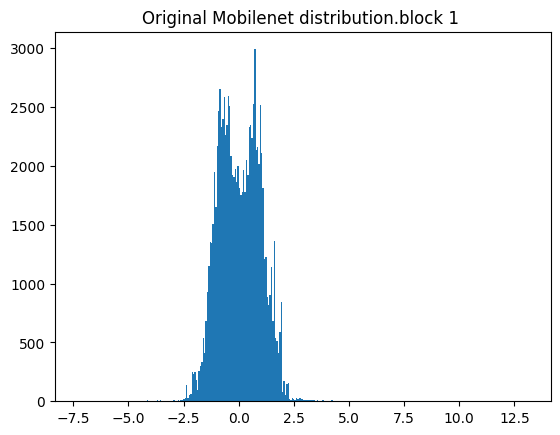

In [22]:
#y = torch.flatten(FP32_model.Conv[0].weight)
y = torch.flatten(output_activation['block1.pw2'])
y = y.cpu()
y = torch.flatten(y)
y = y.detach()
y = y.numpy()
print(y.shape)

plt.title("Original Mobilenet distribution.block 1 ")
plt.hist(y, bins='auto',density=False)

(173056,)


(array([1.5099e+04, 6.4990e+03, 2.1247e+04, 4.6250e+03, 3.3200e+03,
        3.1100e+03, 1.0456e+04, 3.1340e+03, 2.4880e+03, 2.9890e+03,
        1.0057e+04, 2.1770e+03, 2.1690e+03, 2.0470e+03, 1.9640e+03,
        1.8020e+03, 1.9490e+03, 1.7970e+03, 1.7710e+03, 1.7770e+03,
        1.7190e+03, 1.6240e+03, 1.5660e+03, 1.4750e+03, 1.4940e+03,
        1.6540e+03, 9.5370e+03, 1.5310e+03, 1.5570e+03, 1.6240e+03,
        9.2970e+03, 1.0174e+04, 1.4450e+03, 1.4050e+03, 8.8040e+03,
        1.2170e+03, 8.2200e+02, 7.4300e+02, 6.5500e+02, 5.7300e+02,
        6.3000e+02, 5.3100e+02, 5.1900e+02, 5.4200e+02, 6.5300e+02,
        5.6200e+02, 5.9400e+02, 5.1100e+02, 5.3500e+02, 5.1300e+02,
        4.5200e+02, 4.5900e+02, 4.3600e+02, 3.9800e+02, 3.4100e+02,
        3.1900e+02, 2.9600e+02, 2.7700e+02, 3.1700e+02, 3.8100e+02,
        4.1200e+02, 3.4900e+02, 2.4900e+02, 2.0600e+02, 1.8300e+02,
        1.7400e+02, 2.4200e+02, 2.4600e+02, 2.0800e+02, 1.7800e+02,
        1.3500e+02, 1.2900e+02, 1.1000e+02, 1.03

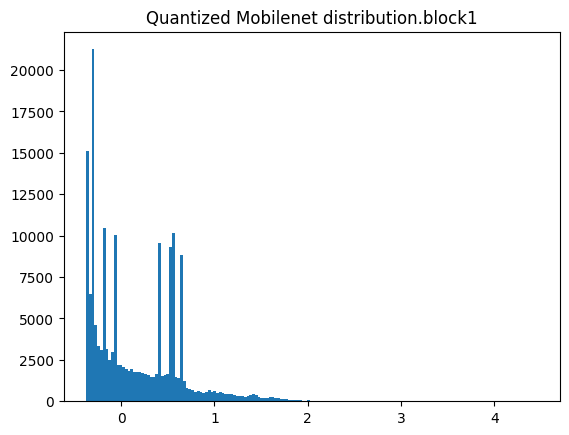

In [23]:
#x = torch.flatten(quantized_weights12)
#x = torch.flatten(quantized_model.Conv[1].weights)
#print(q_output_activation['block7.9'])
x = torch.flatten(q_output_activation['block1.1'])
x = x.cpu()
x = torch.flatten(x)
x = x.detach()
x = x.numpy()
print(x.shape)

plt.title("Quantized Mobilenet distribution.block1")
plt.hist(x, bins='auto',density=False)